# Analysis of Diffraction Grating Measurements
Written by: Taylor Contreras, March 10 2021

This analysis assumes data is output from the DiffractionStudy_Automation.ipynb.

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy import signal
from math import atan, pi
import pandas as pd

In [103]:
import os
current_path = os.getcwd()
current_path

'C:\\Users\\Owner\\Documents\\DiffractionStudies\\metalens'

In [212]:
def GetData(file_name):
    # Get the data

    data = {}
    with open('data/'+file_name) as file:
        reader = csv.reader(file)
        i = 0
        for row in reader:
            if i==2:
                data['WithGrating_pos_led'] = float(row[0])

            if i==4:
                data['WithGrating_pos_sipm'] = np.array([float(row[j]) for j in range(len(row))])

            if i==6:
                data['WithGrating_voltage'] = np.array([float(row[j]) for j in range(len(row))])

            if i==10:
                data['BelowGrating_pos_led'] = float(row[0])

            if i==12:
                data['BelowGrating_pos_sipm'] = np.array([float(row[j]) for j in range(len(row))])

            if i==14:
                data['BelowGrating_voltage'] = np.array([float(row[j]) for j in range(len(row))])

            if i==16:
                data['GRATING_LED_POSITION'] = float(row[1])

            if i==18:
                data['BELOW_GRATING_LED_POSITION'] = float(row[1])

            if i==20:
                data['BELOW_MOUNT_LED_POSITION'] = float(row[1])

            if i==22:
                data['VOLTAGE'] = float(row[1])

            i+= 1
    return data

def ledVoltage_to_sipmPeak(led_V):
    """
    Returns the correct SiPM peak voltage
    based on the LED voltage, to correct
    for sipm saturation. This fit was found
    in the Linearity_Analysis.ipynb using
    a 50ns pulse width. 
    """
    m = 0.014264022538903087
    b = -0.026668937550506203
    
    if led_V < 2.0:
        return 0.0
    
    return m*led_V + b

def corrected_sipm_peaks(sipm_peaks):
    look_up_table = pd.read_csv('sipm_linearity_lookup_table.csv')
    
    led_voltages = np.interp(sipm_peaks, look_up_table.V_sipm, look_up_table.V_led)

    corrected_peaks = []
    for i in range(len(sipm_peaks)):
        if sipm_peaks[i] < 0.025:
            corrected_peaks.append(sipm_peaks[i])
        else:
            corrected_peaks.append(ledVoltage_to_sipmPeak(led_voltages[i]))
        
    return corrected_peaks

def PlotCorrected(data):
    data['cc_BelowGrating_voltage'] = corrected_sipm_peaks(data['BelowGrating_voltage'])
    plt.plot(data['cc_BelowGrating_voltage'],label='corrected')
    plt.plot(data['BelowGrating_voltage'], label='data')
    plt.legend() 
    plt.title('Corrections below grating in '+data['name'])
    plt.show()
    
    data['cc_WithGrating_voltage'] = corrected_sipm_peaks(data['WithGrating_voltage'])
    plt.plot(data['cc_WithGrating_voltage'],label='corrected')
    plt.plot(data['WithGrating_voltage'], label='data')
    plt.legend()
    plt.title('Corrections with grating in '+data['name'])
    plt.show()
    
    halfway = len(data['WithGrating_pos_sipm'])//2
    plt.plot(np.array(data['BelowGrating_pos_sipm'])-data['BELOW_GRATING_LED_POSITION'], data['cc_BelowGrating_voltage'], label='below grating')
    plt.plot(np.array(data['WithGrating_pos_sipm'])-data['GRATING_LED_POSITION'], data['cc_WithGrating_voltage'], label='with grating')
    #plt.plot(np.array(BelowMount_pos_sipm)-BELOW_MOUNT_LED_POSITION, BelowMount_voltage, label='below mount')
    plt.legend()
    plt.ylabel('Max Voltage [V]')
    plt.xlabel('SiPM Position [mm]')
    plt.title('Corrected comparison in '+data['name'])
    plt.show()
    
def GetAngle(data, prominence=0.0005, distance=10, peak_num=0):
    
    # Correct the sipm positions
    BelowGrating_corrected_pos_sipm = np.array(data['BelowGrating_pos_sipm'])-data['BELOW_GRATING_LED_POSITION']
    WithGrating_corrected_pos_sipm = np.array(data['WithGrating_pos_sipm'])-data['GRATING_LED_POSITION']
    
    # Find the peaks and their widths with a large prominence
    wg_peaks, _ = signal.find_peaks(data['cc_WithGrating_voltage'], prominence=0.0005, distance=10)
    print('Peak positions with grating',WithGrating_corrected_pos_sipm[wg_peaks])
    print('Peak voltages with grating', data['WithGrating_voltage'][wg_peaks])
    print('Summed peak height with grating = ', sum([data['cc_WithGrating_voltage'][i] for i in wg_peaks]))
    print('Peak height without grating = ', max(data['cc_BelowGrating_voltage']))
    wg_widths = signal.peak_widths(data['cc_WithGrating_voltage'], wg_peaks)
    wg_prominences, _, _ = signal.peak_prominences(data['cc_WithGrating_voltage'], wg_peaks)
    # The widths includes the position of the FWHM left and right bins
    # Use these to calculate the position of the peak
    if len(wg_peaks) > 1:
        l1 = WithGrating_corrected_pos_sipm[int(wg_widths[2][0])]
        r1 = WithGrating_corrected_pos_sipm[int(wg_widths[3][0])]
        peak1_pos = (r1 + l1)/2.

        l2 = WithGrating_corrected_pos_sipm[int(wg_widths[2][1])]
        r2 = WithGrating_corrected_pos_sipm[int(wg_widths[3][1])]
        peak2_pos = (r2 + l2)/2.

        dist_between_peaks = abs(peak2_pos - peak1_pos)
        
        
        eff = data['WithGrating_voltage'][wg_peaks[peak_num]]/max(data['BelowGrating_voltage'])
    else:
        dist_between_peaks = 0.0
        eff = 0.0
        

    BelowGrating_peaks, _ = signal.find_peaks(data['cc_BelowGrating_voltage'], prominence=0.01)
    BelowGrating_widths = signal.peak_widths(data['cc_BelowGrating_voltage'], BelowGrating_peaks)

    l = BelowGrating_corrected_pos_sipm[int(BelowGrating_widths[2][0])]
    r = BelowGrating_corrected_pos_sipm[int(BelowGrating_widths[3][0])]
    BelowGrating_peak_pos = (r + l)/2
    print('Position of peak below diffraction grating: '+str(round(BelowGrating_peak_pos,3)))

    # Calculate the angle or refraction
    x =  66.4 #37.5 # (36.4 + 35.6)/2. # distance between sipm and lens
    theta = atan(dist_between_peaks/x)

    return [theta*360/(2*pi), eff]

# Analysis

In [241]:
air_data = GetData('run016_air_data_50ns_15sweeps_airgap.csv')
air_data['name'] = 'Air + air gap'
water_data = GetData('run018_distilled_water_data_50ns_15sweeps_airgap.csv')
water_data['name'] = 'Water + air gap'
glucose_data = GetData('run021_distilled_glucose_water_data_50ns_15sweeps_airgap.csv')
glucose_data['name'] = 'Water w/ 30% Glucose + air gap'
no_gap_water_data = GetData('run002_distilled_water_data_50ns_15sweeps.csv')
no_gap_water_data['name'] = 'Water'
no_gap_glucose_data = GetData('run024_distilled_glucose_water_data_50ns_15sweeps_nogap.csv') #'run023_distilled_glucose_water_data_50ns_15sweeps_nogap.csv')
no_gap_glucose_data['name'] = 'Water w/ 30% Glucose'

In [242]:
GetAngle(no_gap_glucose_data, prominence=0.000000005, distance=0)

KeyError: 'cc_WithGrating_voltage'

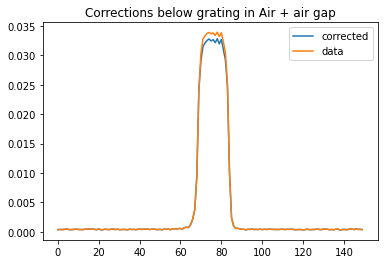

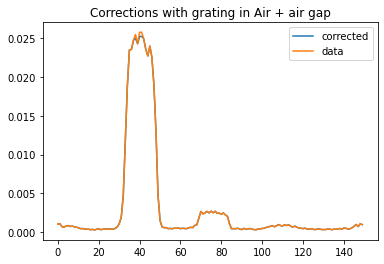

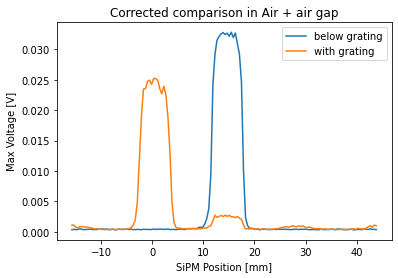

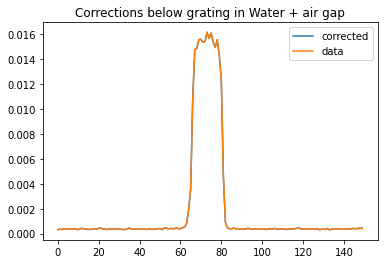

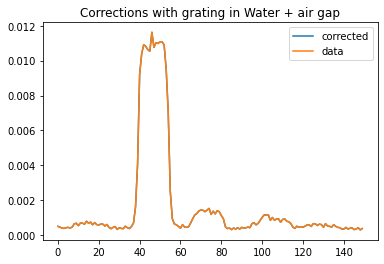

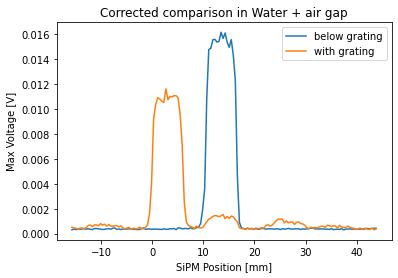

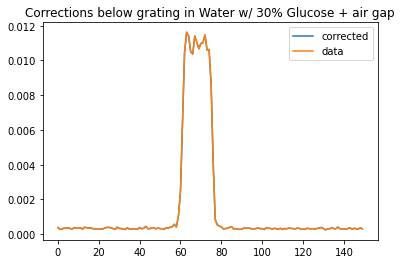

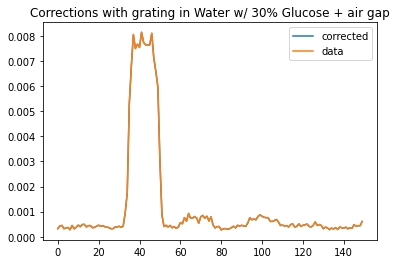

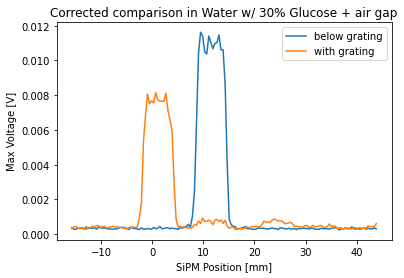

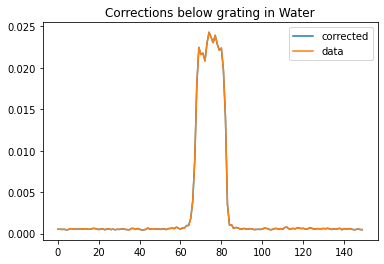

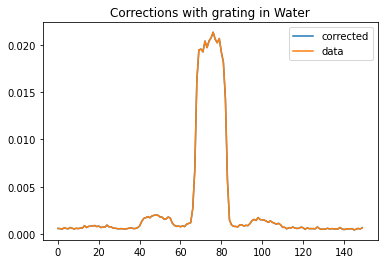

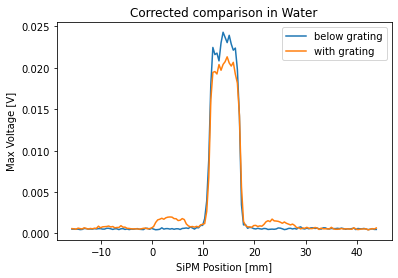

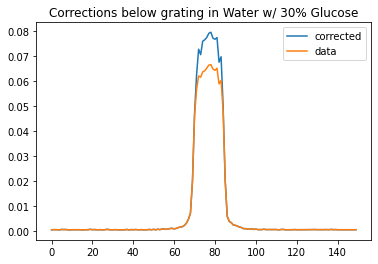

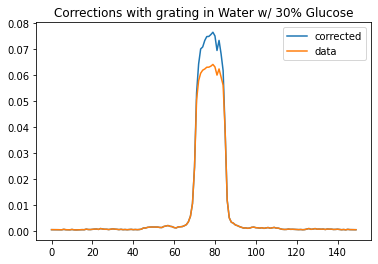

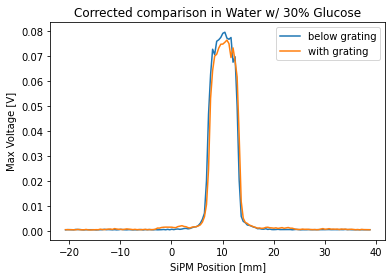

[None, None, None, None, None]

In [243]:
[PlotCorrected(data) for data in [air_data, water_data, glucose_data, no_gap_water_data, no_gap_glucose_data]]

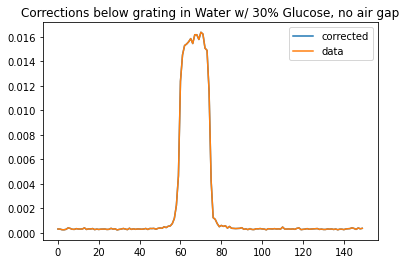

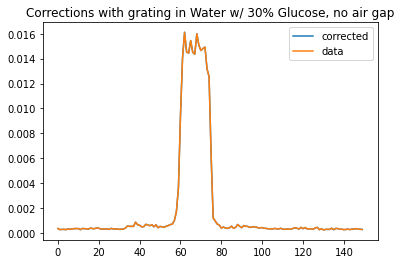

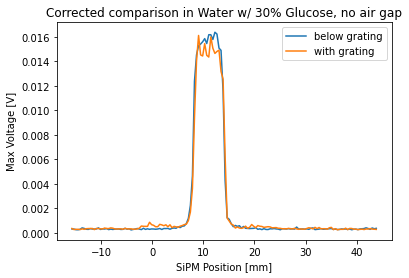

In [216]:
PlotCorrected(no_gap_glucose_data)

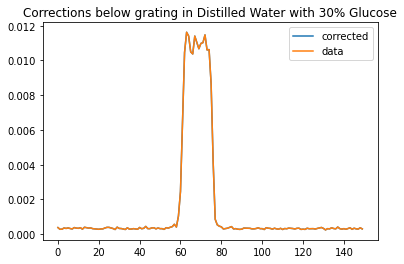

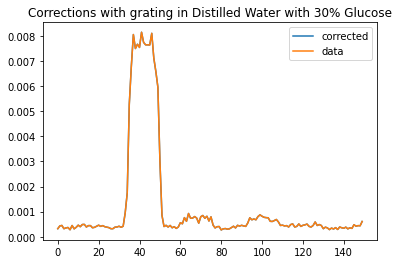

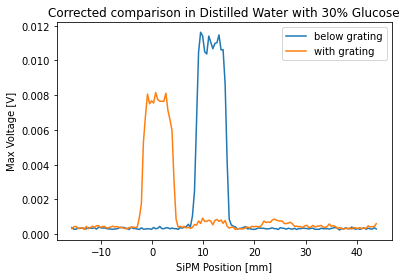

In [108]:
PlotCorrected(glucose_data)

In [244]:
all_data = np.array([GetAngle(data) for data in [air_data, water_data, glucose_data, no_gap_water_data, no_gap_glucose_data]])
names = [data['name'] for data in [air_data, water_data, glucose_data, no_gap_water_data, no_gap_glucose_data]]

Peak positions with grating [ 0.26 14.26 27.46]
Peak voltages with grating [0.02574711 0.0027254  0.00099644]
Summed peak height with grating =  0.028934695652861983
Peak height without grating =  0.032836882572540124
Position of peak below diffraction grating: 14.46
Peak positions with grating [ 2.66 13.86 25.46]
Peak voltages with grating [0.01162318 0.00153392 0.00117217]
Summed peak height with grating =  0.01432926757394171
Peak height without grating =  0.0161753813784458
Position of peak below diffraction grating: 13.26
Peak positions with grating [ 0.655  9.855 23.855]
Peak voltages with grating [0.00815536 0.00092513 0.00087021]
Summed peak height with grating =  0.00995070052238134
Peak height without grating =  0.0116236877906317
Position of peak below diffraction grating: 11.255
Peak positions with grating [ 3.455 14.655 23.455]
Peak voltages with grating [0.00199288 0.02133201 0.00173797]
Summed peak height with grating =  0.025062861608148506
Peak height without grating =

(0.0, 12.149352655245302)

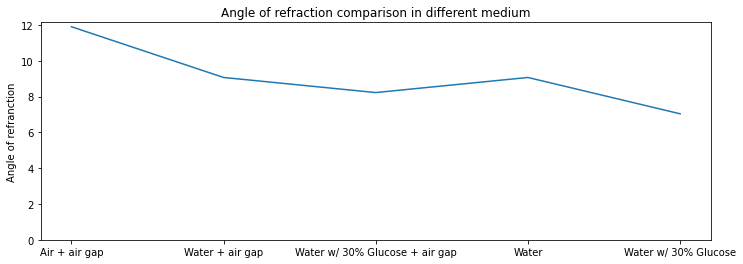

In [254]:
indices = np.linspace(1,len(all_data[:,0]), len(all_data[:,0]))
f = plt.figure()
plt.plot(indices, all_data[:,0], 'o')
plt.xticks(indices, names)
f.set_figwidth(12)
plt.ylabel('Angle of refranction')
plt.title('Angle of refraction comparison in different medium')
plt.ylim(0)

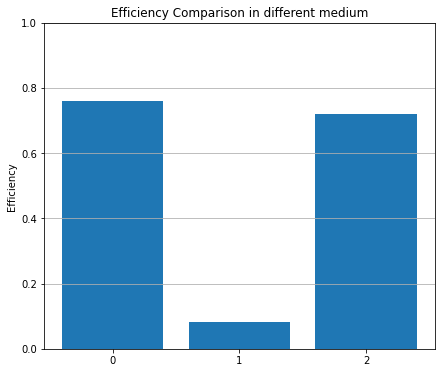

In [270]:
indices = np.linspace(1,len(all_data[:,1]), len(all_data[:,1]))
f = plt.figure()
x = [0,1,2]
y = [all_data[:,1][0],all_data[:,1][3],all_data[:,1][1]]
n = [names[0], names[3], names[1]]
plt.bar(x, y)
plt.xticks(x, )
plt.ylabel('Efficiency')
plt.title('Efficiency Comparison in different medium')
plt.grid(True,axis="y")
plt.ylim(0,1)
f.set_figwidth(7)
f.set_figheight(6)

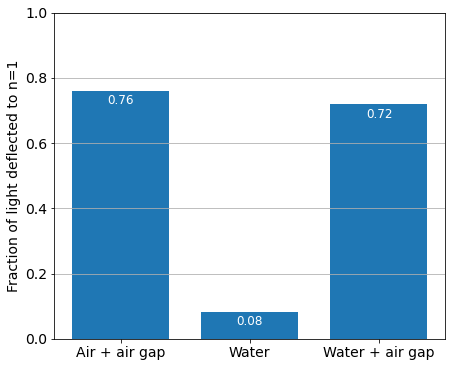

In [301]:
fig, ax = plt.subplots(figsize = (7,6))    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.bar(ind, y, width)
ax.set_xticks(ind)
ax.set_xticklabels(n, minor=False)
ax.set_ylim(0,1)
ax.grid("on", axis="y")
plt.ylabel('Fraction of light deflected to n=1')      
#plt.show()
for i, v in enumerate(y):
    ax.text(i-0.1, v-0.04, str(round(v,2)), color="white", fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.label.set_fontsize(14)